# Bank Marketing  (EDA & Modeling)
Ce Notebook examine `bank.csv`, construit huit modèles de référence et optimise les trois classifieurs les plus performants.

## Contexte du Projet

Ce projet analyse les données d'une **campagne de marketing bancaire** menée par une institution financière portugaise. L'objectif principal est de **prédire si un client va souscrire à un dépôt à terme** (term deposit) suite à une campagne de télémarketing.

### Description du Dataset (`bank.csv`)

Le dataset contient **4521 observations** avec **17 variables** décrivant les caractéristiques des clients et les détails des contacts de la campagne :

#### Variables démographiques :
- **age** : Âge du client
- **job** : Type d'emploi (admin, blue-collar, entrepreneur, etc.)
- **marital** : Statut marital (married, divorced, single)
- **education** : Niveau d'éducation (primary, secondary, tertiary, unknown)

#### Variables financières :
- **default** : A un crédit en défaut ? (yes/no)
- **balance** : Solde du compte bancaire annuel moyen (en euros)
- **housing** : A un prêt immobilier ? (yes/no)
- **loan** : A un prêt personnel ? (yes/no)

#### Variables liées à la campagne :
- **contact** : Type de communication (cellular, telephone, unknown)
- **day** : Dernier jour de contact du mois
- **month** : Dernier mois de contact de l'année
- **duration** : Durée du dernier contact en secondes
- **campaign** : Nombre de contacts effectués pendant cette campagne
- **pdays** : Nombre de jours depuis le dernier contact (-1 = jamais contacté)
- **previous** : Nombre de contacts avant cette campagne
- **poutcome** : Résultat de la campagne précédente (success, failure, unknown, other)

#### Variable cible :
- **y** : Le client a-t-il souscrit à un dépôt à terme ? (yes/no)

### Objectifs de l'Analyse

1. **Analyse Exploratoire des Données (EDA)** : Comprendre les distributions, les corrélations et les patterns dans les données
2. **Prétraitement** : Gérer le déséquilibre des classes, encoder les variables catégorielles, normaliser les features
3. **Modélisation** : Entraîner et comparer 8 algorithmes de classification différents
4. **Optimisation** : Sélectionner les 3 meilleurs modèles et optimiser leurs hyperparamètres avec GridSearchCV
5. **Évaluation** : Comparer les performances avec des métriques appropriées (Accuracy, Precision, Recall, F1-score)

### Enjeux Business

Identifier les facteurs clés qui influencent la décision d'un client de souscrire permettra à la banque de :
- Cibler plus efficacement les prospects
- Optimiser les coûts de la campagne marketing
- Améliorer le taux de conversion global

## Step-1: Import the Required Libraries
Importer toutes les bibliothèques d’analyse, de visualisation, de prétraitement et de modélisation afin que le flux de travail reste reproductible.

In [2]:
! pip install plotly



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.2 kB/s  0:06:14m0:00:0400:09


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.base import clone
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Step-2: Load the Dataset
Le jeu de données de marketing bancaire regroupe des informations sur des campagnes de télémarketing menées par une institution bancaire portugaise. La variable cible (y) indique si un client a souscrit à un dépôt à terme

In [4]:
data_path = 'bank.csv'
bank_df = pd.read_csv(data_path, sep=';').drop_duplicates().reset_index(drop=True)
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Step-3: Data Analysis on the Bank Dataset
Vérifier la structure de base du jeu de données, détecter les doublons, examiner les types de variables et collecter des statistiques descriptives avant de passer à une préparation plus approfondie.

In [5]:
bank_df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [6]:
bank_df.tail(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [7]:
duplicate_rows = bank_df.duplicated().sum()
duplicate_rows

np.int64(0)

In [8]:
bank_df.shape

(4521, 17)

In [9]:
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [10]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [11]:
bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.915284,8.247667,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


## Step-4: Data Preparation
Afin de préparer les données pour la modélisation, il convient de nettoyer les noms de colonnes, de convertir la variable cible en format numérique, d’analyser le déséquilibre des classes, de gérer les valeurs manquantes et d’encoder les variables catégorielles.

In [12]:
# Target engineering
bank_df = bank_df.rename(columns={'y': 'loan_approval'})
bank_df['loan_approval'] = bank_df['loan_approval'].map({'yes': 1, 'no': 0})
target_distribution = bank_df['loan_approval'].value_counts(normalize=True)
missing_values = bank_df.isnull().sum()
target_distribution, missing_values[missing_values > 0]

(loan_approval
 0    0.88476
 1    0.11524
 Name: proportion, dtype: float64,
 Series([], dtype: int64))

In [13]:
categorical_cols = bank_df.select_dtypes(include='object').columns.tolist()
numeric_cols = bank_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'loan_approval']

## Step-5: Exploratory Data Analysis (EDA)
Utiliser des diagrammes en barres, des boxplots, des pairplots et des cartes de corrélation pour comprendre comment la performance de la campagne varie en fonction des caractéristiques démographiques et des paramètres de la campagne.

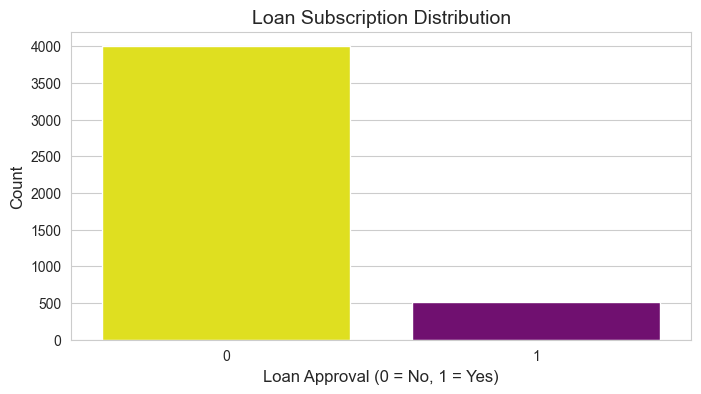

In [14]:
plt.figure(figsize=(8, 4))
plt.title('Loan Subscription Distribution', fontsize=14)
sns.countplot(x='loan_approval', data=bank_df, palette=('#FFFF00', '#800080'))
plt.xlabel('Loan Approval (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

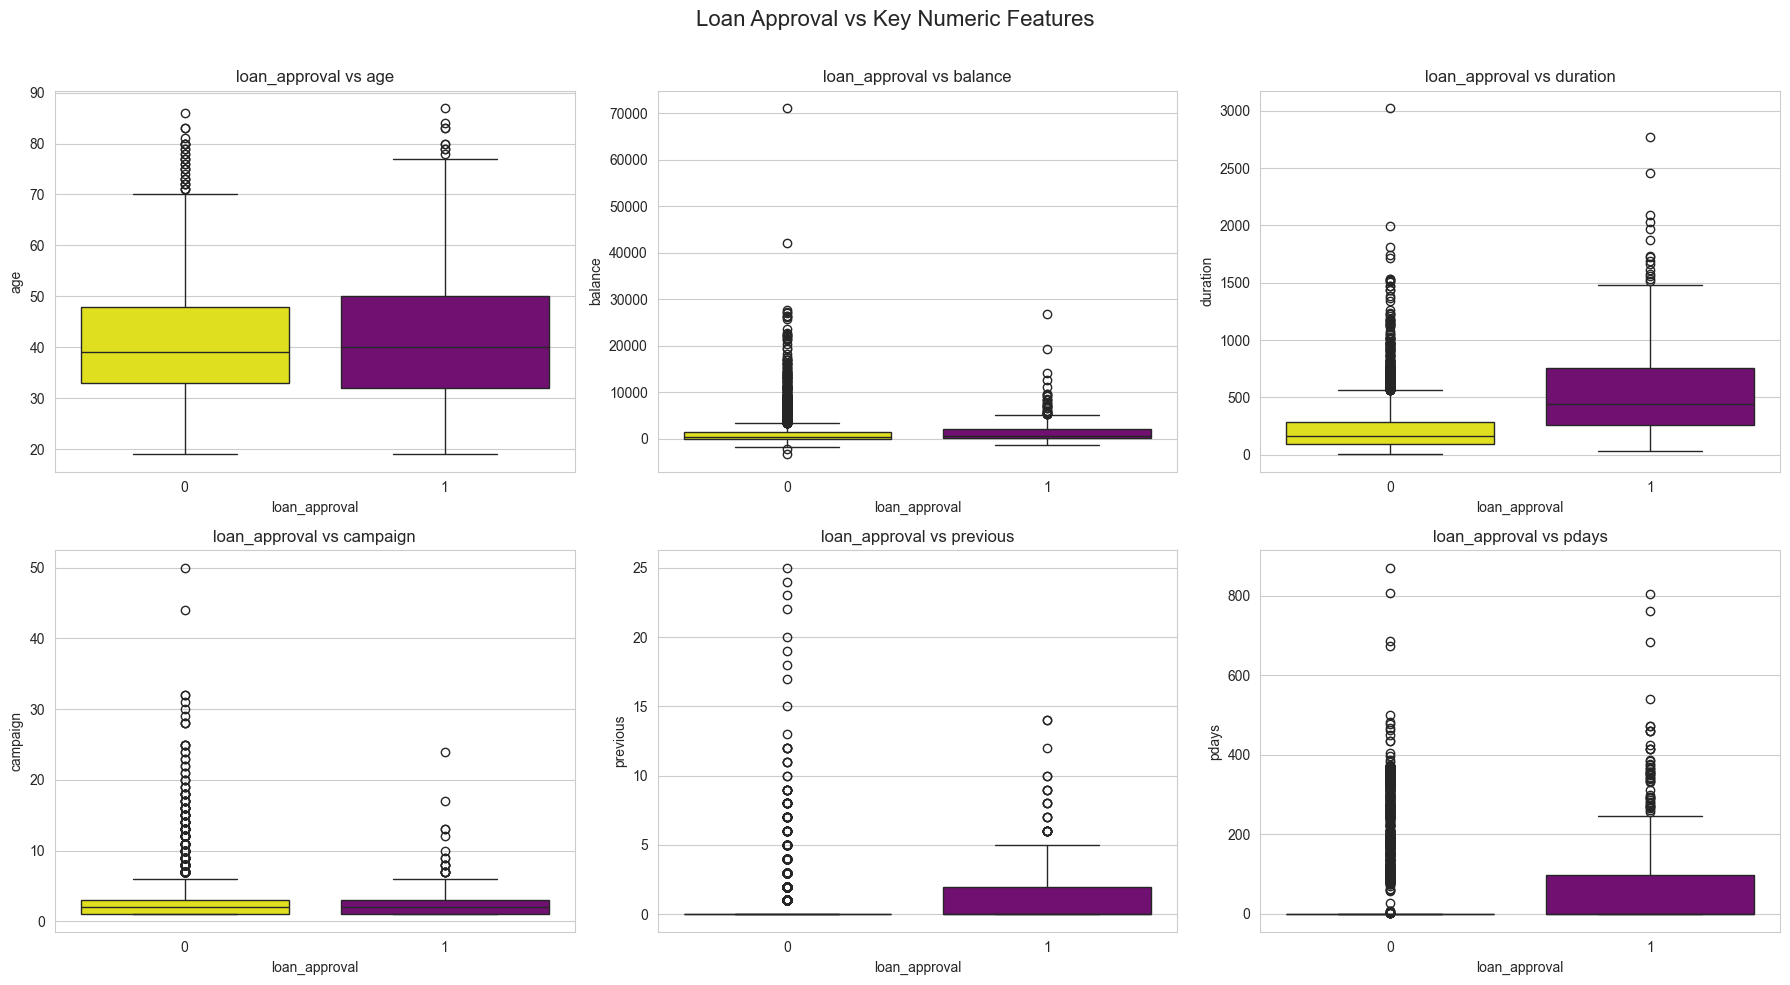

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Loan Approval vs Key Numeric Features', fontsize=16)
feature_list = ['age', 'balance', 'duration', 'campaign', 'previous', 'pdays']
for ax, feature in zip(axes.flatten(), feature_list):
    sns.boxplot(ax=ax, x='loan_approval', y=feature, data=bank_df, palette=('#FFFF00', '#800080'))
    ax.set_title(f'loan_approval vs {feature}', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

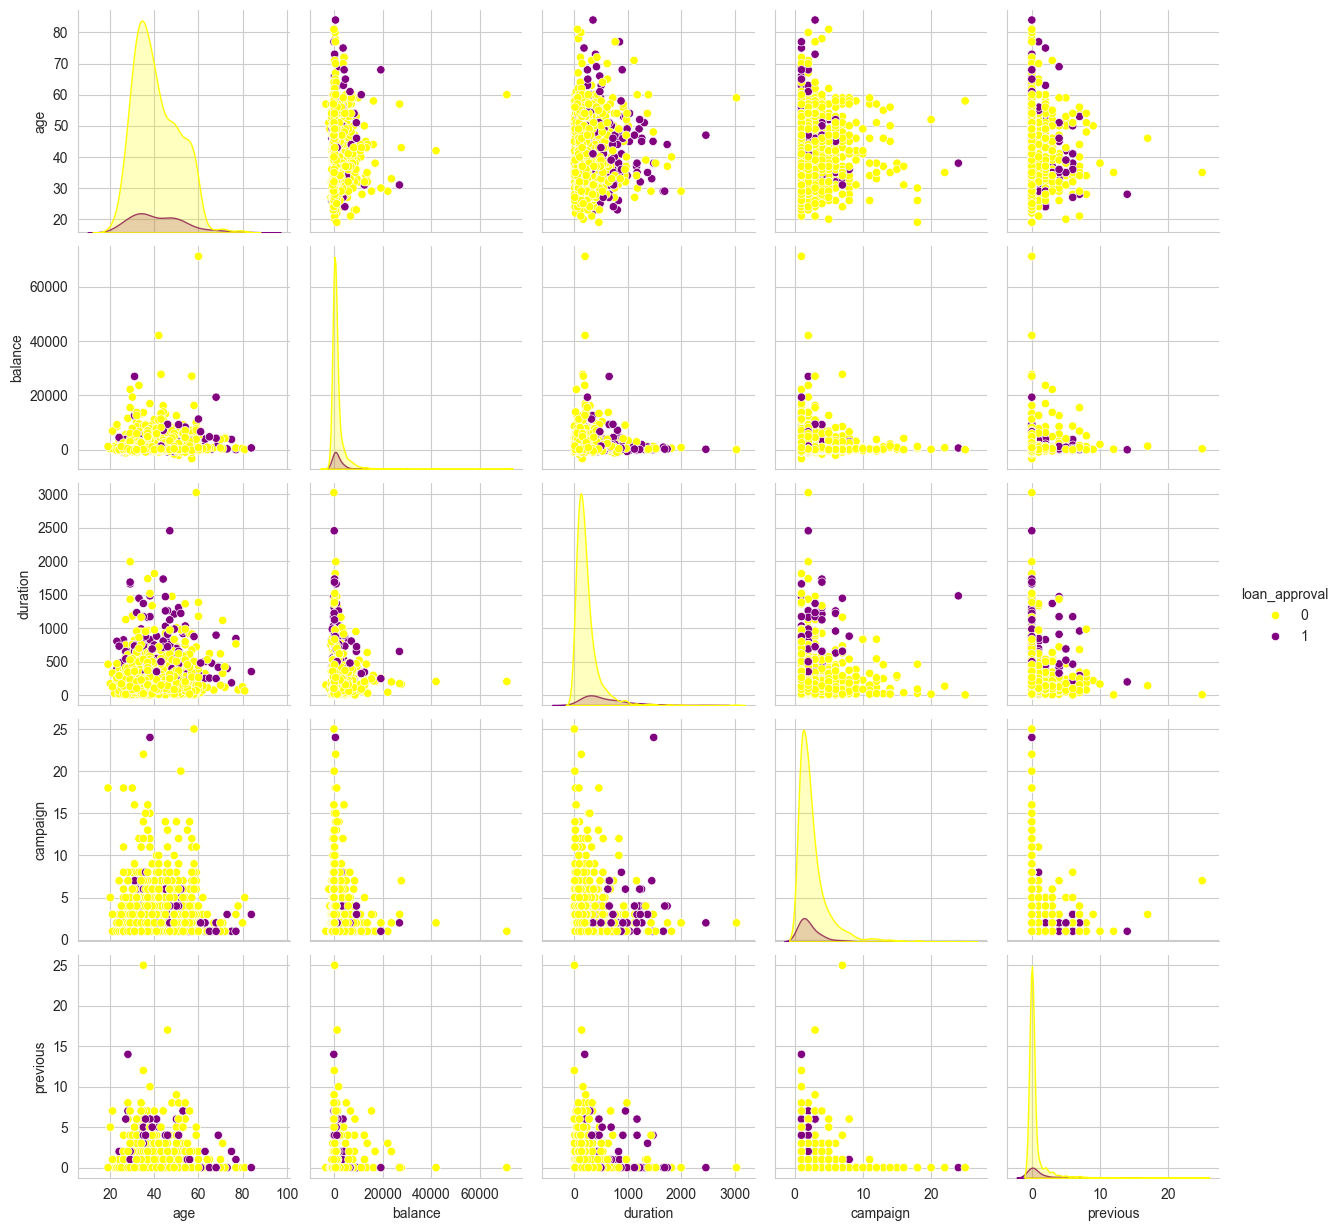

In [16]:
pairplot_cols = ['age', 'balance', 'duration', 'campaign', 'previous', 'loan_approval']
pairplot_sample = bank_df[pairplot_cols].sample(n=min(1500, len(bank_df)), random_state=42)
sns.pairplot(pairplot_sample, hue='loan_approval', palette=('#FFFF00', '#800080'))
plt.show()

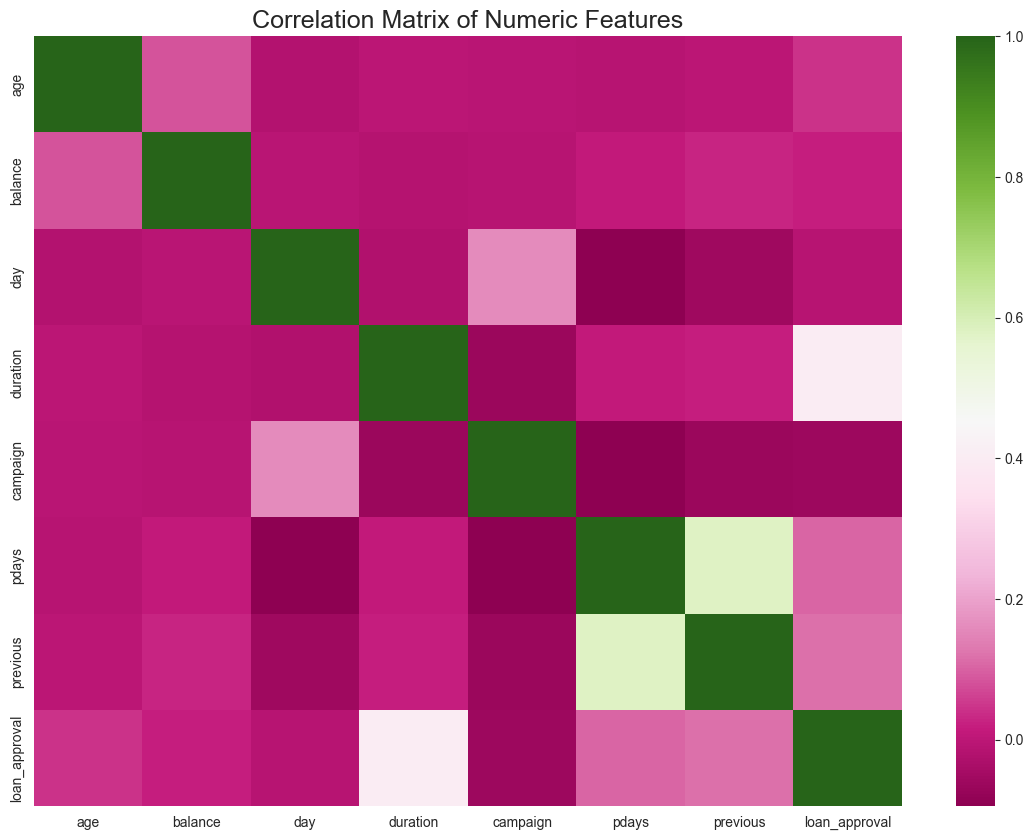

In [17]:
plt.figure(figsize=(14, 10))
corr_matrix = bank_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='PiYG')
plt.title('Correlation Matrix of Numeric Features', fontsize=18)
plt.show()

## Step-6: Model Building
Encoder les variables catégorielles, équilibrer les classes de la variable cible, normaliser les variables explicatives, diviser les données, entraîner huit modèles de classification et comparer leurs performances.

In [18]:
model_df = bank_df.copy()
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)
X = model_df.drop('loan_approval', axis=1)
y = model_df['loan_approval']
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
X_train.shape, X_test.shape, y_train.value_counts()

((6400, 42),
 (1600, 42),
 loan_approval
 1    3200
 0    3200
 Name: count, dtype: int64)

In [19]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=11, weights='distance'),
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

evaluation_records = []
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    evaluation_records.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds)
    })
    fitted_models[name] = model

eval_df = pd.DataFrame(evaluation_records).sort_values(by='F1', ascending=False)
eval_df.reset_index(drop=True)

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.974375,0.951249,1.00000,0.975015
1,Decision Tree,0.956250,0.919540,1.00000,0.958084
2,SVM (RBF),0.910000,0.876147,0.95500,0.913876
3,KNN,0.900625,0.834202,1.00000,0.909608
4,Gradient Boosting,0.873125,0.848308,0.90875,0.877489
5,AdaBoost,0.805000,0.804239,0.80625,0.805243
6,Logistic Regression,0.807500,0.815385,0.79500,0.805063
7,Gaussian NB,0.690625,0.774775,0.53750,0.634686


In [20]:
eval_df

,Model,Accuracy,Precision,Recall,F1
5,Random Forest,0.974375,0.951249,1.00000,0.975015
4,Decision Tree,0.956250,0.919540,1.00000,0.958084
2,SVM (RBF),0.910000,0.876147,0.95500,0.913876
1,KNN,0.900625,0.834202,1.00000,0.909608
7,Gradient Boosting,0.873125,0.848308,0.90875,0.877489
6,AdaBoost,0.805000,0.804239,0.80625,0.805243
0,Logistic Regression,0.807500,0.815385,0.79500,0.805063
3,Gaussian NB,0.690625,0.774775,0.53750,0.634686


In [21]:
top_models = eval_df.head(3)['Model'].tolist()
top_models

['Random Forest', 'Decision Tree', 'SVM (RBF)']

In [22]:
param_grids = {
    'Logistic Regression': {'C': [0.1, 1.0, 5.0], 'solver': ['lbfgs', 'liblinear']},
    'KNN': {'n_neighbors': [5, 9, 13], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    'SVM (RBF)': {'C': [0.5, 1, 5], 'gamma': ['scale', 'auto']},
    'Gaussian NB': {'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Decision Tree': {'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [200, 300, 400], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5]}
}

optimization_results = []

for model_name in top_models:
    base_model = clone(models[model_name])
    grid = param_grids.get(model_name)
    if not grid:
        continue
    grid_search = GridSearchCV(base_model, grid, scoring='f1', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    preds = best_model.predict(X_test)
    optimization_results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds)
    })

optimized_df = pd.DataFrame(optimization_results).sort_values(by='F1', ascending=False)
optimized_df.reset_index(drop=True)

,Model,Best Params,Accuracy,Precision,Recall,F1
0,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.97500,0.952381,1.0000,0.975610
1,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",0.95625,0.919540,1.0000,0.958084
2,SVM (RBF),"{'C': 5, 'gamma': 'auto'}",0.93375,0.895216,0.9825,0.936830


In [23]:
optimized_df

,Model,Best Params,Accuracy,Precision,Recall,F1
0,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.97500,0.952381,1.0000,0.975610
1,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",0.95625,0.919540,1.0000,0.958084
2,SVM (RBF),"{'C': 5, 'gamma': 'auto'}",0.93375,0.895216,0.9825,0.936830
